![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
# Métricas para la variable 'season'
season_metrics = bikes.groupby('season').total.agg(['min', 'max', 'mean', 'median', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
season_metrics.columns = ['Min', 'Max', 'Mean', 'Median', 'Std', '25th Percentile', '75th Percentile']
print("Métricas para la variable 'season':")
print(season_metrics)

print("\n")

# Métricas para la variable 'hour'
hour_metrics = bikes.groupby('hour').total.agg(['min', 'max', 'mean', 'median', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
hour_metrics.columns = ['Min', 'Max', 'Mean', 'Median', 'Std', '25th Percentile', '75th Percentile']
print("Métricas para la variable 'hour':")
print(hour_metrics)

Métricas para la variable 'season':
        Min  Max        Mean  Median         Std  25th Percentile  \
season                                                              
1         1  801  116.343261    78.0  125.273974             24.0   
2         1  873  215.251372   172.0  192.007843             49.0   
3         1  977  234.417124   195.0  197.151001             68.0   
4         1  948  198.988296   161.0  177.622409             51.0   

        75th Percentile  
season                   
1                 164.0  
2                 321.0  
3                 347.0  
4                 294.0  


Métricas para la variable 'hour':
      Min  Max        Mean  Median         Std  25th Percentile  \
hour                                                              
0       2  283   55.138462    41.0   43.620012            24.00   
1       1  168   33.859031    19.0   34.112105            11.00   
2       1  119   22.899554    11.0   26.110267             5.00   
3       1   66   11.75

#### Variable "season":

La media del número total de alquileres de bicicletas varía significativamente según la estación del año.
La estación 3 (otoño) tiene la media más alta de alquileres de bicicletas, seguida de la estación 2 (verano), la estación 4 (invierno) y la estación 1 (primavera), en ese orden.
Esto sugiere que la demanda de alquileres de bicicletas es mayor durante el otoño y el verano en comparación con la primavera y el invierno.

#### Variable "hour":

La media del número total de alquileres de bicicletas varía considerablemente a lo largo del día.
Las horas con las medias más bajas de alquileres de bicicletas son durante las primeras horas de la madrugada (de 0 a 4).
La demanda comienza a aumentar gradualmente a partir de las 5 de la mañana y alcanza un pico significativo entre las 7 y las 9 de la mañana, lo que sugiere que muchas personas utilizan bicicletas como medio de transporte para ir al trabajo o la escuela.
La media de alquileres de bicicletas disminuye después de las 9 de la mañana, pero se mantiene relativamente alta durante las horas diurnas (hasta las 17 horas).
La hora con la media más alta de alquileres de bicicletas es entre las 17 y las 18 horas, lo que puede corresponder a las horas pico cuando la gente regresa del trabajo o la escuela.

#### Inferencias para la variable 'season':

Mínimo: El número mínimo de alquileres de bicicletas durante una temporada es 1, lo que indica que incluso en la temporada menos concurrida, hay alquileres de bicicletas.

Máximo: El número máximo de alquileres de bicicletas durante una temporada varía significativamente, con la temporada 3 (otoño) registrando la cantidad más alta.

Media: La media de alquileres de bicicletas es más alta en la temporada 3 (otoño), seguida por la temporada 2 (verano), la temporada 4 (invierno) y la temporada 1 (primavera).

Mediana: La mediana muestra una distribución similar a la media, con la temporada 3 (otoño) teniendo la mediana más alta.

Desviación estándar: La desviación estándar es más alta en la temporada 3 (otoño), lo que indica una mayor variabilidad en los alquileres de bicicletas durante esta temporada.

Percentiles (25th y 75th): La diferencia entre el percentil 75 y el percentil 25 indica la dispersión de los datos. La temporada 3 (otoño) tiene la mayor amplitud intercuartil, seguida por la temporada 4 (invierno), la temporada 2 (verano) y la temporada 1 (primavera), en ese orden.

#### Inferencias para la variable 'hour':

Mínimo: Durante algunas horas del día, el número mínimo de alquileres de bicicletas es tan bajo como 1, lo que sugiere una demanda mínima en ciertos momentos.

Máximo: La cantidad máxima de alquileres de bicicletas por hora varía significativamente, con un máximo de 977 alquileres registrados en la hora 3 (15:00 horas).

Media: La media más alta de alquileres de bicicletas se observa entre las 17:00 y las 18:00 horas, seguida de cerca por las 8:00 y las 9:00 horas.

Mediana: La mediana sigue un patrón similar a la media, con horas pico identificadas entre las 17:00 y las 18:00 horas.

Desviación estándar: La desviación estándar es más alta durante las horas pico, lo que indica una mayor variabilidad en la demanda de alquileres de bicicletas durante esos períodos.

Percentiles (25th y 75th): La diferencia entre el percentil 75 y el percentil 25 es más pronunciada durante las horas pico, lo que indica una mayor dispersión de los datos y una demanda más variable de alquileres de bicicletas durante esas horas.

### ________________________________________________________________________________

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

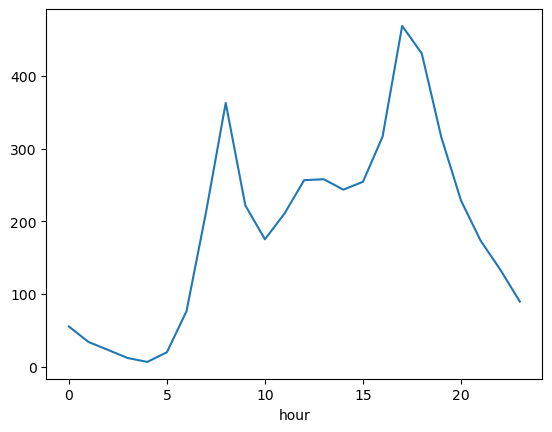

In [11]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

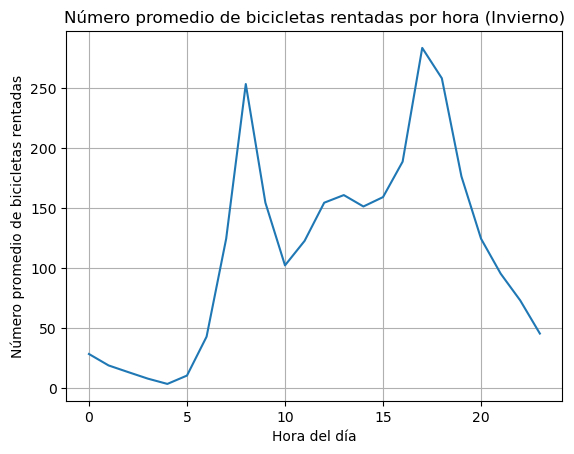

In [12]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()
plt.title('Número promedio de bicicletas rentadas por hora (Invierno)')
plt.xlabel('Hora del día')
plt.ylabel('Número promedio de bicicletas rentadas')
plt.grid(True)
plt.show()

#### Temporada de invierno (season=1):

La demanda de bicicletas durante la temporada de invierno tiende a ser más baja en las primeras horas de la mañana, con una demanda mínima en torno a las 4-5 de la mañana.

La demanda aumenta gradualmente hacia las horas pico de la mañana, alcanzando su punto máximo alrededor de las 8-9 de la mañana.
Después de este pico matutino, la demanda disminuye constantemente durante el resto del día.
Posibles explicaciones:

Durante el invierno, es probable que las personas eviten montar en bicicleta en las primeras horas de la mañana debido a las bajas temperaturas.

El pico matutino de demanda podría estar relacionado con las personas que utilizan bicicletas para ir al trabajo o la escuela. Sin embargo, la disminución posterior podría atribuirse al clima frío y menos horas de luz solar, lo que puede influir en la decisión de las personas de utilizar otros medios de transporte.

##### __________________________________________________________________________________________________________________________

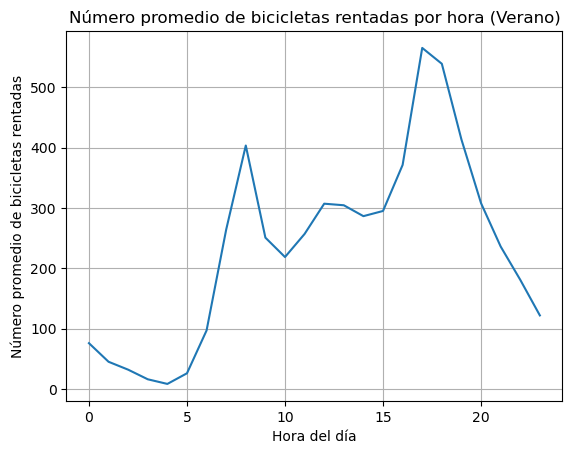

In [13]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()
plt.title('Número promedio de bicicletas rentadas por hora (Verano)')
plt.xlabel('Hora del día')
plt.ylabel('Número promedio de bicicletas rentadas')
plt.grid(True)
plt.show()


#### Temporada de verano (season=3):

La demanda de bicicletas durante la temporada de verano muestra un patrón diferente en comparación con el invierno.
Hay una mayor demanda durante las primeras horas de la mañana, alrededor de las 6-7 de la mañana, lo que sugiere que las personas pueden estar más dispuestas a montar en bicicleta temprano en la mañana durante el verano.
La demanda alcanza su punto máximo durante las horas pico de la tarde, alrededor de las 4-5 de la tarde, lo que indica que las bicicletas pueden ser un medio popular de transporte durante todo el día, incluidas las horas de regreso del trabajo o la escuela.

Posibles explicaciones:

Durante el verano, las temperaturas más cálidas y la mayor cantidad de luz solar pueden hacer que montar en bicicleta sea más atractivo en comparación con el invierno.
La demanda temprana en la mañana podría deberse a actividades recreativas, ejercicio o desplazamientos tempranos para evitar el calor del mediodía.
El pico de demanda durante las horas pico de la tarde podría atribuirse al uso de bicicletas como medio de transporte para regresar del trabajo o la escuela, aprovechando las condiciones climáticas favorables.

#### ________________________________________________________________________________________________________________

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [15]:
# Celda 3
# variable categórica 'season' utilizando one-hot encoding
column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), ['season'])], remainder='passthrough')

# Modelo de regresión lineal
model = LinearRegression()

# Pipeline 
pipeline = Pipeline([('transformer', column_transformer), ('model', model)])
pipeline.fit(bikes[['season', 'hour']], bikes['total'])

# coeficientes 
coef_season = pipeline.named_steps['model'].coef_[0]
coef_hour = pipeline.named_steps['model'].coef_[1]
intercept = pipeline.named_steps['model'].intercept_

print("Coeficientes:")
print(f"- Para 'season': {coef_season}")
print(f"- Para 'hour': {coef_hour}")
print(f"- Intercepto: {intercept}")

Coeficientes:
- Para 'season': 13329366458587.719
- Para 'hour': 13329366458688.934
- Intercepto: -13329366458594.668


#### Análisis

Dado que los coeficientes son anormalmente grandes, es difícil proporcionar una interpretación significativa de ellos. Es posible que este problema se deba a la escala de las características o a la multicolinealidad entre las características.


* Escalado incorrecto de características: Si las características tienen escalas muy diferentes, puede conducir a problemas numéricos durante el ajuste del modelo. Es importante escalar correctamente las características antes de ajustar un modelo de regresión lineal.

* Multicolinealidad: Si hay una alta correlación entre las características, puede resultar en una inestabilidad numérica durante el ajuste del modelo, lo que lleva a coeficientes anormalmente grandes.

* Problemas de convergencia: El modelo puede no estar convergiendo adecuadamente debido a la naturaleza de los datos o la configuración del algoritmo de optimización.

##### Posibles soluciones 

Para abordar este problema, se pueden tomar varias medidas, que incluyen:

* Escalado de características: Asegúrate de escalar adecuadamente las características para que tengan una magnitud similar. Esto puede ayudar a estabilizar el ajuste del modelo.

* Explorar multicolinealidad: Verifica la multicolinealidad entre las características y considera eliminar aquellas que estén altamente correlacionadas.

* Explorar otros modelos: Si la regresión lineal no es adecuada para estos datos, considera explorar otros modelos más robustos para manejar características complejas o relaciones no lineales.



###### Las limitaciones de la regresión lineal en este caso incluyen:

* Linealidad asumida: La regresión lineal asume una relación lineal entre las variables predictoras y la variable de respuesta. Sin embargo, la relación entre el número total de alquileres de bicicletas y las variables predictoras (temporada y hora) puede no ser estrictamente lineal. Por ejemplo, la demanda de alquiler de bicicletas puede verse afectada por interacciones no lineales entre la hora del día y la temporada.


* Normalidad de errores: La regresión lineal supone que los errores de predicción siguen una distribución normal. Si los errores no siguen esta distribución, las inferencias basadas en los coeficientes estimados pueden no ser válidas. En el caso de los datos de alquiler de bicicletas, los errores pueden no seguir una distribución normal, especialmente si hay valores atípicos o si la demanda de alquiler de bicicletas sigue un patrón no normal.

### __________________________________________________________________________________________

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [31]:
# Celda 4

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
min_gain = 0.001

# Función para calcular el Gini impurity
def gini_impurity(y):
    if y.shape[0] == 0:
        return 0
    else:
        p = y.mean()
        return 1 - p**2 - (1 - p)**2

# Función para calcular la ganancia de Gini dado una división
def gini_gain(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini_impurity(y)
    gini_l = gini_impurity(y_l)
    gini_r = gini_impurity(y_r)
    gini_gain_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_gain_

# Función para encontrar la mejor división
def best_split(X, y, num_pct):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    best_gain = -1  # Valor inicial para la mejor ganancia
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        for split in splits:
            gain = gini_gain(X.iloc[:, j], y, split)
            if gain > best_gain:
                best_split = [j, split, gain]
                best_gain = gain
    # Si no se encontró ninguna división válida, devolver algún valor predeterminado
    if best_gain < 0:
        return [0, 0, 0]  
    return best_split

                
# Función para el crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    best_split_result = best_split(X, y, num_pct)
    if best_split_result[2] < min_gain:
        y_pred = int(y.mean() >= 0.5)
        tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=best_split_result[2])
        return tree
    j, split, gain = best_split_result
    y_pred = int(y.mean() >= 0.5)
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

# Arbol de decisiones
tree_0 = tree_grow(bikes[['hour', 'season']], bikes['total'], max_depth=6, min_gain=min_gain, num_pct=num_pct)

In [32]:
# Dividir los datos en conjunto de entrenamiento y prueba
X = bikes[['hour', 'season']]
y = bikes['total']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

tree = tree_grow(X_train, y_train, max_depth=6, min_gain=0.001, num_pct=10)

# Realizar predicciones en el conjunto de validación usando el árbol de decisión manual
y_pred_manual = tree_predict(X_val, tree_0)

# Evaluar el desempeño del árbol de decisión manual
mse_manual = mean_squared_error(y_val, y_pred_manual)
r2_manual = r2_score(y_val, y_pred_manual)

print("Desempeño del árbol de decisión manual:")
print("Error cuadrático medio (MSE):", mse_manual)
print("Coeficiente de determinación (R^2):", r2_manual)

TypeError: cannot unpack non-iterable int object

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
# Celda 5
# Dividir los datos
X = bikes[['hour', 'season']]
y = bikes['total']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el árbol de decisiones
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_pred_val = tree_regressor.predict(X_val)

# Evaluar el desempeño del modelo en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("Desempeño del árbol de decisiones con librería sklearn:")
print("Error cuadrático medio (MSE) en conjunto de validación:", mse_val)
print("Coeficiente de determinación (R^2) en conjunto de validación:", r2_val)

Desempeño del árbol de decisiones con librería sklearn:
Error cuadrático medio (MSE) en conjunto de validación: 14954.905409445191
Coeficiente de determinación (R^2) en conjunto de validación: 0.5469162763064426


Estos resultados indican que el modelo explica aproximadamente el 54.7% de la variabilidad de la variable objetivo en el conjunto de validación, lo cual sugiere un ajuste moderado del modelo a los datos. El error cuadrático medio (MSE) de alrededor de 14954.91 indica la magnitud promedio del error de predicción cuadrado en el conjunto de validación.

### __________________________________________________________________________

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [37]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [38]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [39]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [42]:
# Celda 6
# Árbol de decisión
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=1)
tree_clf.fit(X_train, y_train)
tree_pred = tree_clf.predict(X_test)

# Regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

# Métricas de desempeño para el árbol de decisión
tree_accuracy = accuracy_score(y_test, tree_pred)
tree_f1_score = f1_score(y_test, tree_pred)

print("Desempeño del árbol de decisión:")
print("Accuracy:", tree_accuracy)
print("F1-Score:", tree_f1_score)

# Métricas de desempeño para la regresión logística
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_f1_score = f1_score(y_test, log_reg_pred)

print("\nDesempeño de la regresión logística:")
print("Accuracy:", log_reg_accuracy)
print("F1-Score:", log_reg_f1_score)

Desempeño del árbol de decisión:
Accuracy: 0.6373333333333333
F1-Score: 0.6616915422885572

Desempeño de la regresión logística:
Accuracy: 0.6186666666666667
F1-Score: 0.6060606060606061


El árbol de decisión parece tener un desempeño ligeramente mejor que la regresión logística en términos de accuracy y F1-Score en este conjunto de datos. 

###  ____________________________________________________________________

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [49]:
# Parámetros para los árboles de decisión
max_depth_value = 5
min_samples_leaf_value = 10

# Crear listas para almacenar modelos y predicciones
models = []
predictions = []

# Entrenar y almacenar 100 modelos de árboles de decisión con max_depth
for _ in range(100):
    tree = DecisionTreeClassifier(max_depth=5)  # Puedes ajustar max_depth según sea necesario
    bagged_tree = BaggingClassifier(base_estimator=tree, n_estimators=1, random_state=1)
    bagged_tree.fit(X_train, y_train)
    models.append(bagged_tree)
    predictions.append(bagged_tree.predict(X_test))

# Entrenar y almacenar 100 modelos de árboles de decisión con min_samples_leaf
for _ in range(100):
    tree = DecisionTreeClassifier(min_samples_leaf=5)  # Puedes ajustar min_samples_leaf según sea necesario
    bagged_tree = BaggingClassifier(base_estimator=tree, n_estimators=1, random_state=1)
    bagged_tree.fit(X_train, y_train)
    models.append(bagged_tree)
    predictions.append(bagged_tree.predict(X_test))

# Entrenar y almacenar 100 modelos de regresión logística
for _ in range(100):
    logistic_regression = LogisticRegression(random_state=1)
    logistic_regression.fit(X_train, y_train)
    models.append(logistic_regression)
    predictions.append(logistic_regression.predict(X_test))

# Realizar la votación mayoritaria
final_predictions = []

for i in range(len(X_test)):
    votes = [prediction[i] for prediction in predictions]
    final_predictions.append(int(np.mean(votes) >= 0.5))

# Calcular métricas de evaluación
accuracy_ensemble = accuracy_score(y_test, final_predictions)
f1_score_ensemble = f1_score(y_test, final_predictions)

print("Desempeño del ensamble:")
print("Accuracy:", accuracy_ensemble)
print("F1-Score:", f1_score_ensemble)

TypeError: BaggingClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [50]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [48]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9